In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

dej = [255, 172, 255]
drm = [0, 255, 190]
epi = [160, 48, 112]
ker = [224, 224, 224]
bkg = [0, 0, 0]

bkg_vset = [i for i in range(248, 256)]
epi_vset = [i for i in range(125, 200)]
drm_vset = [i for i in range(210, 249)]

np.set_printoptions(suppress=True)

In [2]:
def list_files(directory):
    files = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            files.append(filename)
    return files

In [3]:
def histogram(img, mask, color):
    temp = np.all(mask == color, axis=-1)
    freq = np.bincount(img[temp].flatten(), minlength=256)
    return freq

In [5]:
def CCA(image, vSet):
    label = np.zeros(image.shape, dtype=int)
    label_counter = 0

    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            if image[i][j] in vSet:
                uniqueL = uniqueNeighbors(label, [i, j])
                uniqueL = [i for i in uniqueL if i != 0]

                if len(uniqueL) == 0:
                    label_counter += 1
                    label[i][j] = label_counter
                    continue
                
                if len(uniqueL) == 1:
                    label[i][j] = uniqueL[0]

                else:
                    label[i][j] = uniqueL[0]
                    replace_indices = np.isin(label, uniqueL[1:])

                    label[replace_indices] = uniqueL[0]
                    # label_counter -= (len(uniqueL[1:]))

    return label_counter - 1, label


def uniqueNeighbors(image, index):
    direction = [[0, -1], [-1, 0], [-1, -1], [-1, 1]]
    neighbors = []

    for x in direction:
        i = index[0] + x[0]
        j = index[1] + x[1]

        if i < 0 or i >= image.shape[0]:
            continue
        elif j < 0 or j >= image.shape[1]:
            continue

        neighbors.append(int(image[i][j]))

    return np.sort(np.unique(neighbors))

In [6]:
img = np.array([[255,   255,    0,      255,    0,      0],
                [255,   0,      255,    255,    0,      255],
                [255,   255,    255,    0,      0,      255],
                [0,     0,      0,      0,      255,    0],
                [0,     255,    0,      255,    255,    0],
                [0,     0,      255,    0,      0,      0]])
print(CCA(img, [255]))

(3, array([[1, 1, 0, 1, 0, 0],
       [1, 0, 1, 1, 0, 3],
       [1, 1, 1, 0, 0, 3],
       [0, 0, 0, 0, 3, 0],
       [0, 3, 0, 3, 3, 0],
       [0, 0, 3, 0, 0, 0]]))


In [7]:
def detectBackground(img):
    ret, thresh = cv.threshold(img, bkg_vset[0], 255, cv.THRESH_BINARY)
    num_of_labels, labels = CCA(thresh, [255])
    output = np.zeros_like(img)

    label_freq = np.bincount(labels.flatten(), minlength=num_of_labels)
    max_label = np.argmax(label_freq[1:]) + 1
    
    if np.sum(label_freq[max_label]) >= 2000:
        output[labels == max_label] = np.uint8(1)

    return output

In [8]:
def detectLayer(img, vset, mostFreq=False, threshold = 180):
    num_of_labels, labels = CCA(img, vset)
    output = np.zeros_like(img)

    label_freq = np.bincount(labels.flatten(), minlength=num_of_labels)

    if mostFreq:
        label_freq = np.bincount(labels.flatten(), minlength=num_of_labels)
        max_label = np.argmax(label_freq[1:]) + 1
    
        if np.sum(label_freq[max_label]) >= 2000:
            output[labels == max_label] = np.uint8(1)
        
    else:
        for label in range(1, num_of_labels):
            if label_freq[label] > threshold:
                output[labels == label] = np.uint8(1)


    return output

In [9]:
def postProcessing(img, layer_code, threshold=220):
    image = np.copy(img)

    num_of_labels, labels = CCA(img, [0])
    label_counts = np.bincount(labels.flatten(), minlength=num_of_labels)

    for label in range(1, num_of_labels):
        if label_counts[label] <= threshold:
            image[labels == label] = layer_code

    return image

In [10]:
def tissueGraySave():
    files = list_files("Train_renamed/Tissue")
    for file in files:
        img = cv.imread(f"Train_renamed/Tissue/{file}", 0)
        cv.imwrite(f"Train_renamed/Tissue_gray/{file[:-4]}.png", img)

In [37]:
def applyColor(img):
    background_img_color = (np.zeros((512, 512, 3), dtype=np.uint8) * 255)

    background_img_color[img == 1] = [0, 55, 55]
    background_img_color[img == 2] = drm
    background_img_color[img == 3] = epi
    background_img_color[img == 4] = ker
    background_img_color[img == 5] = dej

    return background_img_color

In [12]:
img = cv.imread("Train_renamed/Tissue/21.jpg", 0)
# img = cv.imread("Test/tissue/RA23-01882-A1-1-PAS.[13312x1536].jpg", 0)


## Background (BKG Black)

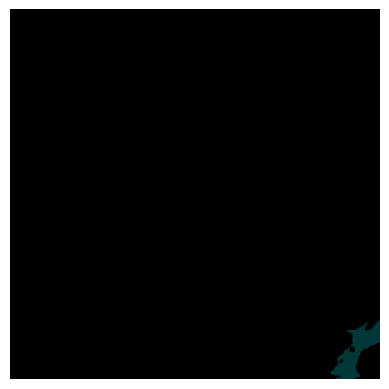

In [13]:
background_img_raw = detectBackground(img)
background_img_color = applyColor(background_img_raw)

plt.imshow(background_img_color)
plt.axis('off')
plt.show()

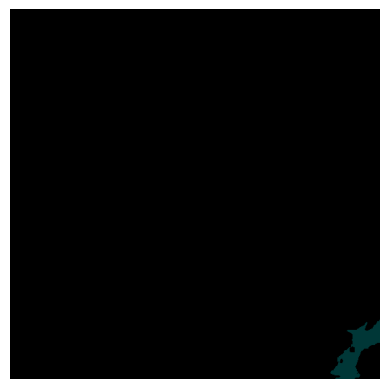

In [14]:
background_img = postProcessing(background_img_raw, 1, 50)
background_img_color = applyColor(background_img)

plt.imshow(background_img_color)
plt.axis('off')
plt.show()

## Dermis (DRM Green)

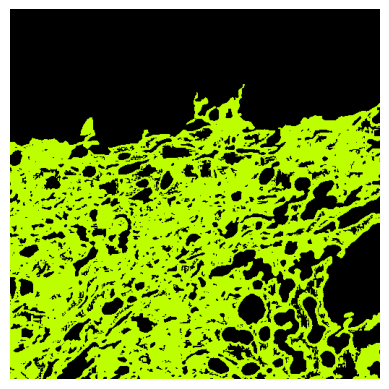

In [15]:
vset_drm = [i for i in range(20, 60)] +[i for i in range(185, 253)]
drm_img_raw = detectLayer(img, vset_drm, True) * 2
drm_img_color = applyColor(drm_img_raw)

plt.imshow(drm_img_color)
plt.axis('off')
plt.show()

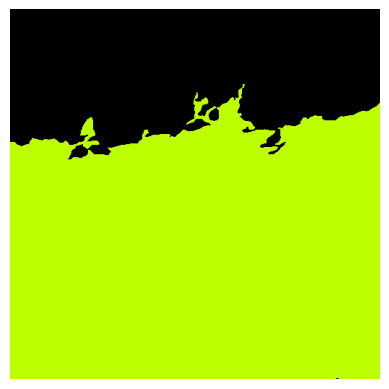

In [35]:
total_pixels_drm = np.count_nonzero(drm_img_raw)
drm_img = postProcessing(drm_img_raw, 2, threshold= int(total_pixels_drm * 0.1))
drm_img_post_color = applyColor(drm_img)

plt.imshow(drm_img_post_color)
plt.axis('off')
plt.show()

## Epidermis (EPI purple)

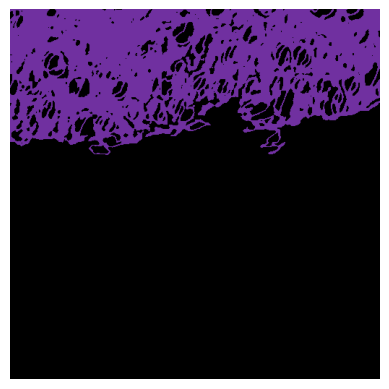

In [17]:
epi_img_raw = detectLayer(img, [i for i in range(110, 180)], True) * 3
epi_img_color = applyColor(epi_img_raw)

plt.imshow(epi_img_color)
plt.axis('off')
plt.show()

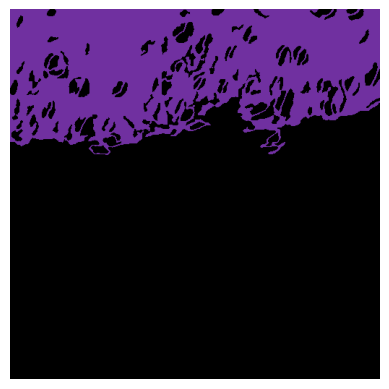

In [18]:
epi_img = postProcessing(epi_img_raw, 3, threshold=50)
epi_img_post_color = applyColor(epi_img)

plt.imshow(epi_img_post_color)
plt.axis('off')
plt.show()

## Keratin (KER Gray)

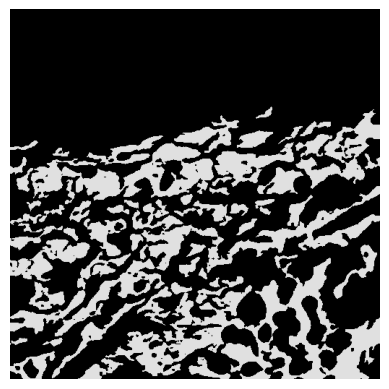

In [19]:
vset_ker = [i for i in range(235, 256)]
ker_img = detectLayer(img, vset_ker, threshold=100) * 4
ker_img_color = applyColor(ker_img)

plt.imshow(ker_img_color)
plt.axis('off')
plt.show()

## Dermal-Epidermal Junction (DEJ PINK)

In [20]:
# ker_img = postProcessing(ker_img, 4)
# ker_img_post_color = applyColor(ker_img)

# plt.imshow(ker_img_post_color)
# plt.axis('off')
# plt.show()

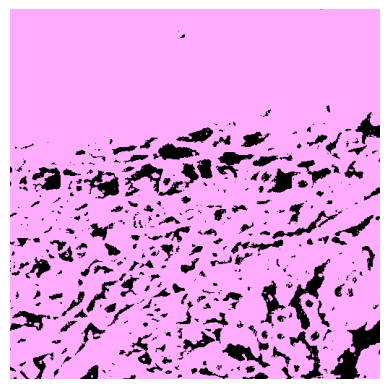

In [21]:
vset_dej = [i for i in range(40, 250)]
dej_img = detectLayer(img, vset_dej, threshold=0) * 5
dej_img_color = applyColor(dej_img)

plt.imshow(dej_img_color)
plt.axis('off')
plt.show()

In [22]:
def combineDEJ(img, dej_img, width=45):
    dej_img_pad = np.pad(dej_img, ((width, width), (width, width)), mode='constant', constant_values=0)
    img_pad = np.pad(img, ((width, width), (width, width)), mode='constant', constant_values=0)
    img_to_change = np.copy(img_pad)

    for i in range(width, img_pad.shape[0]):
        for j in range(width, img_pad.shape[1]):
            neighborhood = img_pad[i - width: i + width, j - width: j + width]

            count_2 = np.count_nonzero(neighborhood == 2)
            count_3 = np.count_nonzero(neighborhood == 3)

            if count_3 != 0:
                ratio_drm_epi = count_2 / count_3
                if (0.2 < ratio_drm_epi <= 1):
                    img_to_change[i, j] = 5
    
    return img_to_change[width:-width, width:-width]


## Combining

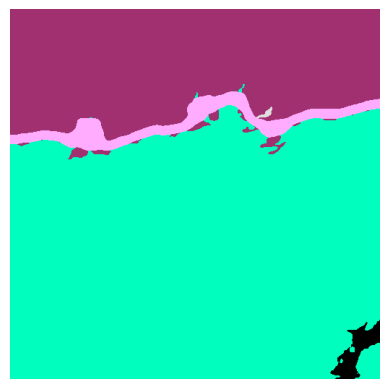

True

In [39]:
output = np.copy(background_img)
# output[background_img == 0] = drm_img[background_img == 0]

output[(background_img == 0) & (ker_img == 4)] = 4
output[(background_img == 0) & (drm_img == 2)] = 2
output[(background_img == 0) & (epi_img_raw == 3)] = 3

output[output == 0] = 3

output = combineDEJ(output, dej_img, 20)

output_color = applyColor(output)
output_color[np.all(output_color == [0, 55, 55], axis=-1)] = [0, 0, 0]

plt.imshow(output_color)
plt.axis('off')
plt.show()

cv.imwrite("haha.png", output_color)

## Creating Masks

In [49]:
def train_hist_func(color):
    train_hist = np.zeros((1, 256))
    for i in range(1, 27):
        img = cv.imread(f"Train_renamed/Tissue/{i}.jpg", 0)
        mask = cv.imread(f"Train_renamed/masks/{i}.png")
        train_hist += histogram(img, mask, color)

    scaled = (train_hist / np.sum(train_hist.flatten())) * 100
    
    plt.title("Background")
    plt.xlabel("Intensity")
    plt.ylabel("Percentage")
    plt.plot(scaled.flatten())


In [41]:
filenames = list_files("Train/Tissue")

for fName in filenames:
    cv.imread(f"Train/Tissue/{fName}")
    

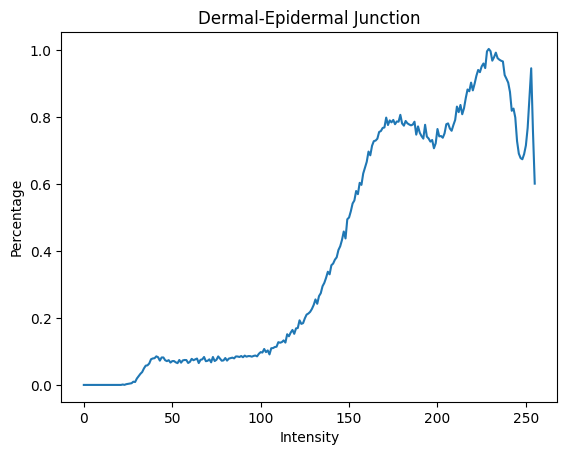

In [42]:
train_hist_func(dej)

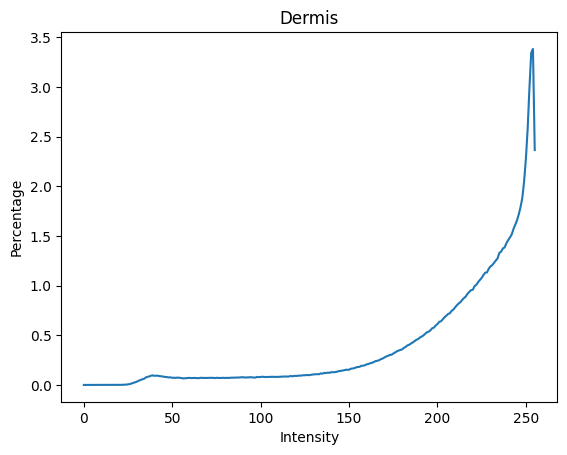

In [44]:
train_hist_func(drm)

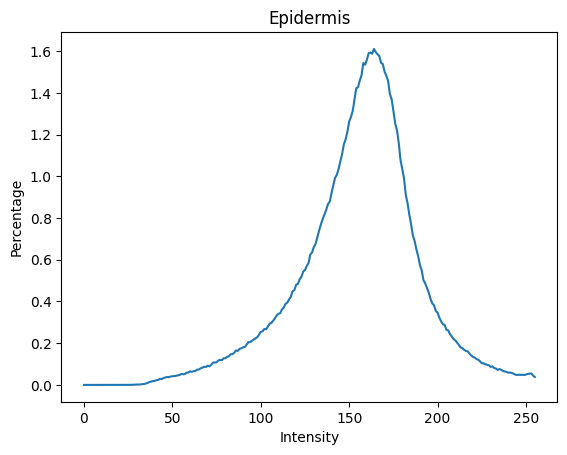

In [46]:
train_hist_func(epi)

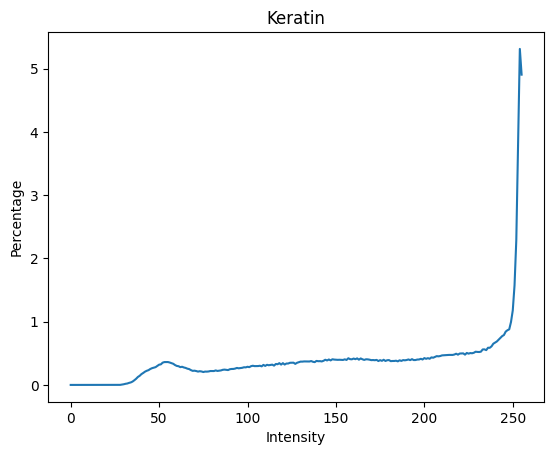

In [48]:
train_hist_func(ker)

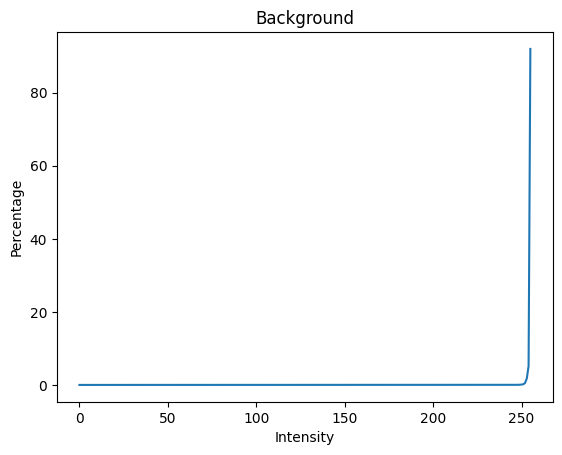

In [50]:
train_hist_func(bkg)

In [53]:
def dice_coff(my_mask, original_mask):
    total_area = original_mask.shape[0] * original_mask.shape[1]
    # Computing number of overlapping pixels
    overlap = 0
    for i in range(original_mask.shape[0]):
        for j in range(original_mask.shape[1]):
            if (my_mask[i, j] == original_mask[i, j]).all():
                overlap += 1
    print(overlap, total_area)
    return overlap / total_area

In [55]:
filenames = list_files("Train_Output")
with open("dice_coeff.txt", "w") as file:
    for fName in filenames:
        img = cv.imread(f"Train_Output/{fName}", 0)
        img2 = cv.imread(f"Train/masks/{fName}", 0)
        
        dice_coefficient = dice_coff(img, img2)
        file.write(f"{fName}: {dice_coefficient}\n")


220286 262144
236896 262144
232606 262144
248791 262144
217912 262144
248626 262144
242462 262144
147791 262144
181749 262144
236111 262144
180915 262144
201696 262144
250931 262144
253041 262144
219509 262144
260647 262144
246379 262144
211488 262144
240121 262144
212555 262144
254441 262144
193683 262144
254380 262144
249584 262144
211119 262144
245250 262144
